In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import paired_distances
from helpers.iaml01cw2_helpers import *

/afs/inf.ed.ac.uk/user/s18/s1864480/miniconda3/envs/py3iaml/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence


In [2]:
%matplotlib inline

In [3]:
Xtrn, Ytrn, Xtst, Ytst = load_FashionMNIST("fashionMNIST/")

In [4]:
Xtrn_orig = Xtrn.copy()
Xtst_orig = Xtst.copy()

In [5]:
Xtrn /= 255.0
Xtst /= 255.0

In [6]:
Xmean = np.mean(Xtrn, axis=0)
Xmean.shape

(784,)

In [7]:
Xtrn_nm = Xtrn - Xmean
Xtst_nm = Xtst - Xmean

In [8]:
# 1.1
np.round(Xtrn_nm[0, :4], 4), np.round(Xtrn_nm[-1, :4], 4)

(array([-0.    , -0.    , -0.0001, -0.0004]),
 array([-0.    , -0.    , -0.0001, -0.0004]))

The first four elements of the first and the last training are same. These are $[-3.13725490e-06, -2.26797386e-05, -1.17973856e-04, -4.07058824e-04]$

In [9]:
# 1.2
def find_index(x):
    return (Xtrn == x).all(axis=1).nonzero()[0][0]

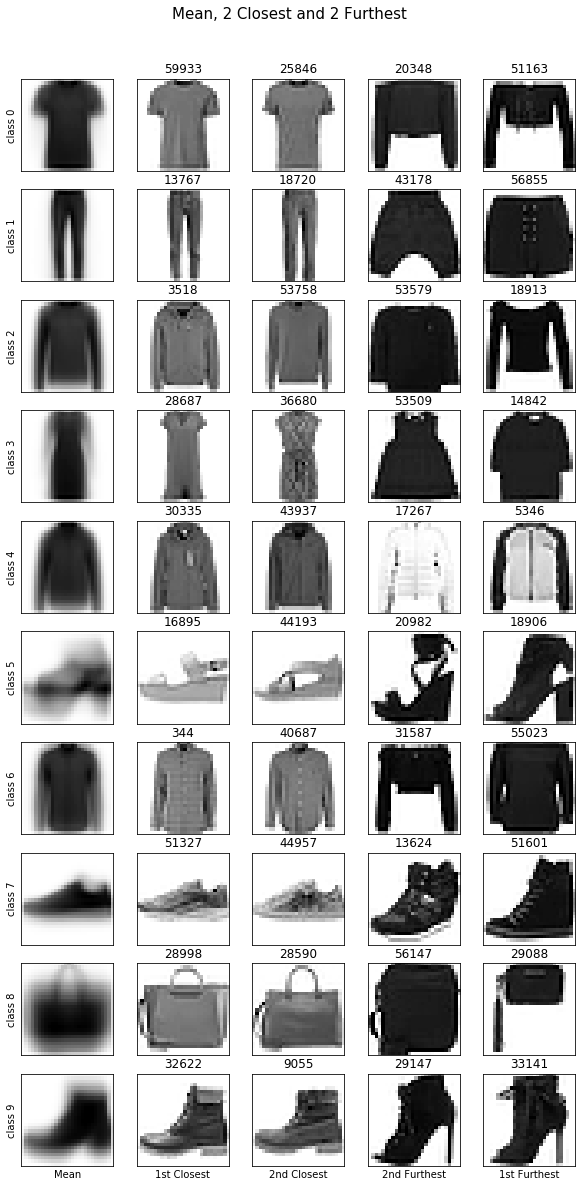

In [21]:
# Setting up the subplots
fig, ax = plt.subplots(nrows=10, ncols=5, sharex="col", sharey="row", figsize=(10, 20))
plt.setp(ax, xticks=[], yticks=[])      

for i in range(10):
    mask = Ytrn == i
    class_vecs = Xtrn[mask]
    class_mean_vec = class_vecs.mean(axis=0)
    dists = np.linalg.norm(class_vecs - class_mean_vec, axis=1)
    dists_sorted = dists.argsort()
    max_1, max_2 = class_vecs[dists_sorted[-1]], class_vecs[dists_sorted[-2]]
    min_1, min_2 = class_vecs[dists_sorted[0]], class_vecs[dists_sorted[1]]
    to_plot = [class_mean_vec, min_1, min_2, max_2, max_1]
    vec_indices = list(map(find_index, to_plot[1:]))
    
    for j in range(5):
        ax[i, 0].set_ylabel(f"class {i}")
        if j != 0:
            ax[i, j].title.set_text(f"{vec_indices[j - 1]}")
        img = to_plot[j].reshape((28, 28))
        ax[i, j].imshow(img, cmap="gray_r")

ax[-1, 0].set_xlabel("Mean")
ax[-1, 1].set_xlabel("1st Closest")
ax[-1, 2].set_xlabel("2nd Closest")
ax[-1, 3].set_xlabel("2nd Furthest")
ax[-1, 4].set_xlabel("1st Furthest")
fig.suptitle("Mean, 2 Closest and 2 Furthest", fontsize=15, y=0.93)
plt.savefig("results/1_2.png")
plt.show()

In [21]:
# 1.3
pca = PCA(n_components=784).fit(Xtrn_nm)
# np.cumsum(pca.explained_variance_)

In [18]:
np.round(pca.explained_variance_[:5], 4)

array([19.8098, 12.1122,  4.1062,  3.3818,  2.6248])

The explained variances of the first five components are $[19.8098, 12.1122,  4.1062,  3.3818,  2.6248]$

In [23]:
pca = PCA(n_components=784).fit(Xtrn_nm)

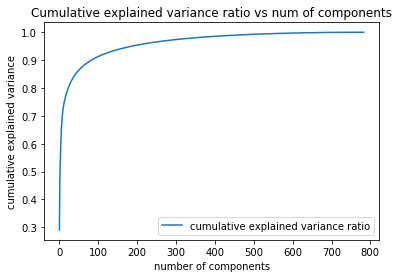

In [24]:
# 1.4
plt.plot(np.cumsum(pca.explained_variance_ratio_), label="cumulative explained variance ratio")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Cumulative explained variance ratio vs num of components")
plt.legend()
plt.savefig("results/1_4.png")
plt.show()

This curve shows how much of the total, 784-dimensional variance is contained within the first $N$ components. Here we can see that in the dataset the first 100 components contain approximately 90% of the variance, while we need around 500 components to describe close to 100% of the variance.

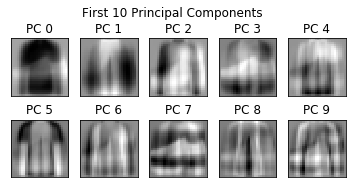

In [26]:
# 1.5
pca_comp_to_plot = pca.components_[:10]
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(6, 3))
plt.setp(ax, xticks=[], yticks=[])
# fig.tight_layout()
fig.subplots_adjust(hspace=0)
for i in range(2):
    for j in range(5):
        image = pca_comp_to_plot[5*i + j].reshape((28,28))
        ax[i, j].title.set_text(f"PC {5*i + j}")
        ax[i, j].imshow(image, cmap='gray_r')
fig.suptitle("First 10 Principal Components", y=0.97)
plt.savefig("results/1_5.png")
plt.show()

In [27]:
# 1.6
K = [5,20,50,200]
pca_dict = {k: PCA(k).fit(Xtrn_nm) for k in K}
class_rmses = {}
for i in range(10):
    mask = Ytrn == i
    class_vecs = Xtrn_nm[mask]
    first_sample = class_vecs[0].reshape(1, 784)
    rmses = []
    for k in K:
        first_sample_pca = pca_dict[k].transform(first_sample)
        first_sample_new = pca_dict[k].inverse_transform(first_sample_pca)
        rmse = mean_squared_error(first_sample, first_sample_new) ** 0.5
        rmses.append(rmse)
    class_rmses[i] = rmses

In [33]:
import pprint
pprint.pprint(class_rmses)

{0: [0.2561486679020725,
     0.1500892354921341,
     0.12703138803031508,
     0.06192152556366967],
 1: [0.19802439734525823,
     0.14043961990008383,
     0.09515083615810914,
     0.03608825462718256],
 2: [0.19870015164195384,
     0.1455371070243711,
     0.12240319986611722,
     0.07978625752632186],
 3: [0.1456579794161617,
     0.10745779875803224,
     0.08376159738077145,
     0.05605463798860008],
 4: [0.11820870578550868,
     0.10261077199180907,
     0.08702815075394557,
     0.046574647348171974],
 5: [0.18112975915426077,
     0.158566728305961,
     0.14312571252004028,
     0.08975860745716015],
 6: [0.129479278959279,
     0.09625428995452849,
     0.07253194953049792,
     0.04460895059361141],
 7: [0.16562538300681998,
     0.12720755629496458,
     0.10589197995990776,
     0.061395021193739276],
 8: [0.22339658731390297,
     0.1449166929794325,
     0.12331006981380582,
     0.09302866037302879],
 9: [0.18351042077149526,
     0.15132015731960202,
     0.121

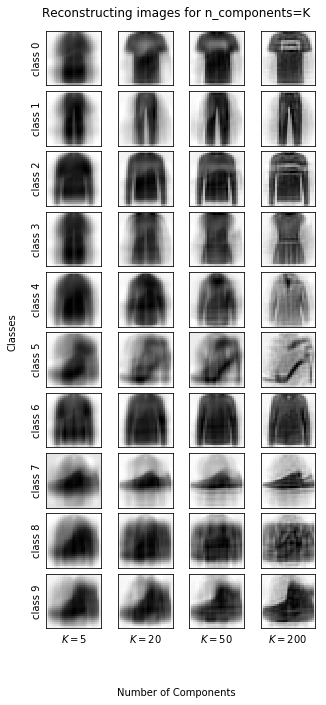

In [32]:
# 1.7
fig, ax = plt.subplots(10, 4, figsize=(5, 11),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
K = [5,20,50,200]
pca_dict = {k: PCA(k).fit(Xtrn_nm) for k in K}
for i in range(10):
    mask = Ytrn == i
    class_vecs = Xtrn[mask]
    first_sample = class_vecs[0].reshape(1, 784)
    rmses = []
    ax[i, 0].set_ylabel(f"class {i}")
    for j, k in enumerate(K):
        first_sample_pca = pca_dict[k].transform(first_sample)
        first_sample_new = pca_dict[k].inverse_transform(first_sample_pca)
        image = (Xmean + first_sample_new).reshape(28, 28)
        ax[i, j].imshow(image, cmap="gray_r")
ax[-1, 0].set_xlabel("$K=5$")
ax[-1, 1].set_xlabel("$K=20$")
ax[-1, 2].set_xlabel("$K=50$")
ax[-1, 3].set_xlabel("$K=200$")

fig.text(0.5, 0.04, 'Number of Components', ha='center')
fig.text(0.03, 0.5, 'Classes', va='center', rotation='vertical')
fig.suptitle("Reconstructing images for n_components=K", y=0.91)
plt.savefig("results/1_7.png")
plt.show()

In [34]:
# 1.8
pca_2d = PCA(2)  # project from 784 to 2 dimensions
projected = pca_2d.fit_transform(Xtrn_nm)

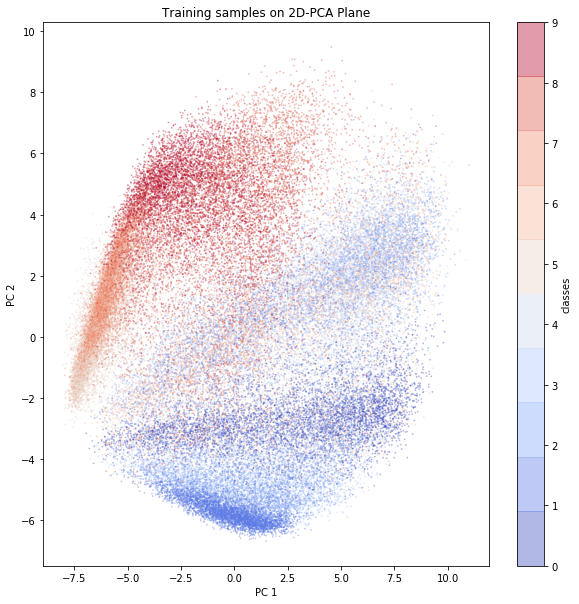

In [36]:
plt.figure(figsize=(10, 10))
plt.scatter(projected[:, 0], projected[:, 1],
            s=3, c=Ytrn, edgecolor='none',
            alpha=0.4, cmap=plt.cm.get_cmap('coolwarm', 10))
plt.xlabel("PC 1")
plt.ylabel("PC 2")
cbar = plt.colorbar()
cbar.ax.set_ylabel('classes')
plt.title("Training samples on 2D-PCA Plane")
plt.savefig("results/1_8.png")
plt.show()